# Transformer

## Config
### Imports

In [1]:
# basic
import os
import math

# display
from IPython.display import clear_output
from tqdm.notebook import tqdm
from bertviz import head_view, model_view

# Data
from dataclasses import dataclass
from datasets import load_dataset, Dataset
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Machine leaning
import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken

### Global variables

In [2]:
train_dataset_size = 500000

## Utils Functions

### Tokenizer

In [3]:
class Tokenizer():
    """A tokenizer class for encoding/decoding text sequences."""

    def __init__(self):
        """
        Constructor method to initialize special token indices and tokenizer encoding. 
        """
        # Initialize special token indices
        self.BOS_IDX: int = 100264  # Index for the Beginning of Sentence token
        self.EOS_IDX: int = 100265  # Index for the End of Sentence token
        self.PAD_IDX: int = 100266  # Index for the Padding token

        # Initialize base encoding from tiktoken
        cl100k_base = tiktoken.get_encoding("cl100k_base")

        # Initialize the tokenizer's encoding with special tokens added
        self.encoder = tiktoken.Encoding(
            name="cl100k_bep", # Name for the encoder with BOS, EOS, and PAD tokens added
            pat_str=cl100k_base._pat_str, # Pattern string from the base encoding
            mergeable_ranks=cl100k_base._mergeable_ranks, # Mergeable ranks from the base encoding
            special_tokens={
                **cl100k_base._special_tokens, # Special tokens from the base encoding
                "<|bos|>": self.BOS_IDX,  # BOS token
                "<|eos|>": self.EOS_IDX,  # EOS token
                "<|pad|>": self.PAD_IDX,  # PAD token
            }
        )
        
    def vocab_size(self) -> int:
        """
        Method to return the size of the vocabulary in the tokenizer's encoding.

        Returns:
            int: The size of the vocabulary.
        """
        return self.encoder.n_vocab


    def sequence_padding(self, sequence, max_size: int = 512, device: str = "cpu") -> torch.Tensor:
        """
        Method to add BOS/PAD/EOS special tokens and ensure the sequence length is within the maximum size.

        Args:
            sequence (torch.Tensor or list): The input sequence.
            max_size (int, optional): The maximum allowed size for the sequence. Defaults to 512.
            device (str, optional): The device where the tensors will be allocated. Defaults to "cpu".

        Returns:
            torch.Tensor: The processed sequence with special tokens added and length limited.
        """
        assert max_size > 2, f"[max_size]: {max_size} should be greater than 2"
        # Ensure the sequence is a torch tensor
        tensor_sequence = torch.tensor(sequence, dtype=torch.long).to(device) if not torch.is_tensor(sequence) else sequence.to(device)

        # Limit the sequence length within (max_size - 2) where 2 corresponding to bos and eos tags
        cutted_sequence_size = max(0, min(max_size - 2, tensor_sequence.size()[0]))
        tensor_sequence = tensor_sequence[:cutted_sequence_size]
        
        # Add BOS token
        tensor_sequence = torch.cat([torch.tensor([self.BOS_IDX], dtype=torch.long, device=device), tensor_sequence], dim=0)

        # Calculate the padding size
        padding_size = max_size - tensor_sequence.size()[0] - 1 # expected size - current size - EOS tag

        # Create PAD tensor
        pad_tensor = torch.full((padding_size,), self.PAD_IDX, dtype=torch.long, device=device)

        # Add PAD and EOS tokens
        tensor_sequence = torch.cat([tensor_sequence, pad_tensor, torch.tensor([self.EOS_IDX], dtype=torch.long, device=device)], dim=0)
        
        return tensor_sequence
    
    def sequence_cleaner(self, sequence):
        """ Method used to remove BOS/PAD/EOS special tokens """
        # Checking tensor format
        list_sequence = sequence.tolist() if torch.is_tensor(sequence) else sequence
        def check_special(number):
            return number not in [self.BOS_IDX, self.EOS_IDX, self.PAD_IDX]
        return list(filter(check_special, list_sequence))

    def tokenize(self, sequence, device="cpu") -> list:
        """
        Method to generate a str list of separated tokens token.

        Args:
            sequence (torch.Tensor or list): The input sequence.
            device (str, optional): The device where the tensors will be allocated. Defaults to "cpu".

        Returns:
            list: The processed sequence converted in a list of tokens in string format.
        """
        # Ensure the sequence is a torch tensor
        tensor_sequence = torch.tensor(sequence, dtype=torch.long).to(device) if not torch.is_tensor(sequence) else sequence.to(device)
        # create batch of idx tokens
        tensor_sequence = tensor_sequence.unsqueeze(0).T
        # decode all batch to recreate list of separated tokens 
        tensor_sequence = self.encoder.decode_batch(tensor_sequence.detach().tolist())
        return tensor_sequence

    def tokenize_from_str(self, sequence, device="cpu") -> list:
        return self.tokenize(self.encoder.encode(sequence), device)

### TransformerConfig
Data class that stores the configuration for a Transformer model, and training 

In [4]:
@dataclass
class TransformerConfig:
    """Data class that stores the configuration for a Transformer model.

    Attributes:
        - tokenizer: An instance of the Tokenizer class.
        - block_size (int): Number of tokens in each sequence. Defaults to 512.
        - batch_size (int): Number of sequences in each batch. Defaults to 12.
        - vocab_size (int): Total size of the tokenizer vocabulary. It is set to the size of the tokenizer vocabulary.
        - n_layer (int): Number of transformer encoder and decoder blocks (N). Defaults to 1.
        - n_head (int): Number of heads in each attention block. Defaults to 2.
        - n_embd (int): Token embedding size. This is from the original Transformer paper. Defaults to 128.
        - dropout (float): Dropout rate to use in the Transformer model. Defaults to 0.1.
        - bias (bool): Indicates whether to use bias in Linears and LayerNorms.
            If True, bias is used similar to GPT-2.
            If False, it is a bit better and faster. Defaults to False.
        - device (str): The device to run the model on. Defaults to 'cpu'. 'cuda' is used if a GPU is available.
        - learning_rate (float): Learning rate for the model optimization. Defaults to 3e-4.
        - max_iters (int): Number of training steps. Defaults to 20.
        - eval_interval (int): Number of steps between each validation dataset. Defaults to 5.
        - eval_iters (int): Number of validation epochs. Defaults to 20.
        - visualize (bool): Define if we want to get the attention scores.
    """
    tokenizer: any
    block_size: int = 512
    batch_size: int = 12
    n_layer: int = 4 # 6
    n_head: int = 6 # 8
    n_embd: int = 512 # 512
    dropout: float = 0.1
    bias: bool = False # True:
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = 'cpu'
    learning_rate = 3e-4
    max_iters: int = 200
    eval_interval: int = 25
    eval_iters: int = 20 # 200
    visualize: bool = False

    @property
    def vocab_size(self) -> int:
        """Returns the total size of the tokenizer vocabulary.

        Returns:
            int: The size of the tokenizer vocabulary.
        """
        return self.tokenizer.vocab_size()

### Dataset
Classes used to managed train val and test dataset

In [5]:
class TranslationDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.

    Args:
        - dataset (Dataset): a dataset from HuggingFace datasets library.
        - tokenizer (Tokenizer): The custom tiktoken tokenizer used to encode sequences.
        - block_size (int): The maximum sequence length for tokenization.
    """

    def __init__(self, dataset, tokenizer, block_size):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.block_size = block_size

    def __getitem__(self, index):
        """
        Get a tokenized example from the dataset at the specified index.

        Args:
            - index (int): the index of the example to fetch.

        Returns:
            - Dict: dictionary with keys 'inputs', 'targets' and 'translation', containing tokenized input,
            target sequences and original translation.
        """
        translation = self.dataset[index]['translation']
        encode = self.tokenizer.encoder.encode
        inputs = self.tokenizer.sequence_padding(encode(translation['en']), self.block_size) # source language
        targets = self.tokenizer.sequence_padding(encode(translation['fr']), self.block_size) # target language
        return {'inputs': inputs, 'targets': targets, 'translation': translation}

    def __len__(self) -> int :
        """
        Returns the length of the dataset.

        Returns:
            - int: the length of the dataset.
        """
        return self.dataset.num_rows


class DataLoaderFactory():
    """
    A class to instantiate PyTorch DataLoaders for different splits of a HuggingFace Dataset.

    Args:
        - block_size (int): The maximum sequence length for tokenization.
        - batch_size (int): The batch size for DataLoader.
        - tokenizer (Tokenizer): a tokenizer that has an encode method.
        - device (str): 'cpu' or 'cuda', depending on whether we use CPU or GPU.
    """

    def __init__(self, block_size, batch_size, tokenizer, device):
        self.train_data = TranslationDataset(load_dataset("wmt14", "fr-en", split=f"train[:{train_dataset_size}]"), tokenizer, block_size)
        self.val_data = TranslationDataset(load_dataset("wmt14", "fr-en", split="validation"), tokenizer, block_size)
        self.test_data = TranslationDataset(load_dataset("wmt14", "fr-en", split="test"), tokenizer, block_size)

        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device

        self.dataloader_train = DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.dataloader_val = DataLoader(self.val_data, batch_size=batch_size, shuffle=True)
        self.dataloader_test = DataLoader(self.test_data, batch_size=batch_size, shuffle=True)

    
    
    def __len__(self) -> int :
        """
        Print the length of each dataset and returns the length of all datasets.

        Returns:
            - int: the length of all dataset (train + val + test).
        """
        print("\033[95m\033[1m\033[4mNumber of data by datasets splits\033[0m")
        print(f"Train\t\t: {len(self.train_data)}\t-> {len(self.train_data)/self.batch_size}")
        print(f"Validation\t: {len(self.val_data)}\t\t-> {len(self.val_data)/self.batch_size}")
        print(f"Test\t\t: {len(self.test_data)}\t\t-> {len(self.test_data)/self.batch_size}")
        total = len(self.train_data) + len(self.val_data) + len(self.test_data)
        print(f"Total\t\t: {total}")
        return total

    def get_batch(self, split):
        """
        Choose the correct DataLoader and yield batches from it.

        Args:
            - split (str): 'train', 'val' or 'test'.

        Yields:
            - Dict: a dictionary with keys 'inputs', 'targets' and 'translation', containing a batch of tokenized input,
            target sequences and original translation.
        """
        # choose the correct dataloader
        if split == 'train':
            dataloader = self.dataloader_train
        elif split == 'val':
            dataloader = self.dataloader_val
        else:
            dataloader = self.dataloader_test

        for batch in dataloader:
            # Separate the 'translation' from the rest of the batch
            translation = batch.pop('translation')
    
            # Move tensors to device
            batch_on_device = {k: v.to(self.device) for k, v in batch.items()}
    
            # Add 'translation' back into the batch
            batch_on_device['translation'] = translation
    
            yield batch_on_device

## Transformer Classes
### LayerNorm

In [6]:
class LayerNorm(nn.Module):
    """A Layer Normalization module with optional bias.

    This implementation of Layer Normalization allows turning off the bias term,
    which is not directly supported by PyTorch's layer normalization function.

    Attributes:
        weight: Learnable weights for the layer normalization. Initialized as an all ones tensor.
        bias: Learnable biases for the layer normalization. Initialized as an all zeros tensor 
              if bias argument in constructor is True, otherwise it's set to None.

    Args:
        ndim: An integer for the dimension of the input vectors.
        bias: A boolean which, if True, adds a learnable bias to the output.

    """
    def __init__(self, ndim: int, bias: bool):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        """Defines the computation performed at every call.

        Args:
            input (tensor): The input tensor to be normalized.

        Returns:
            tensor: The normalized input tensor.

        """
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

### Multi Head Self Attention

In [7]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention module.
    
    This module applies multi-head attention mechanism on the input sequence. This implementation doesn't apply mask over the attention scores.
    
    Attributes:
        - n_head (int): Number of attention heads.
        - n_embd (int): Embedding dimensionality.
        - dropout (float): Dropout rate.
        - q_attn (nn.Linear): Linear layer for the query projection.
        - k_attn (nn.Linear): Linear layer for the key projection.
        - v_attn (nn.Linear): Linear layer for the value projection.
        - c_proj (nn.Linear): Linear layer for the output projection.
        - attn_dropout (nn.Dropout): Dropout layer for the attention scores.
        - resid_dropout (nn.Dropout): Dropout layer for the residual connection.
        - flash (bool): Flag indicating if flash attention is available.
    """
    def __init__(self, config):
        """
        Constructor for the MultiHeadAttention class.
        
        Args:
            - config: The configuration object containing model parameters.
        """
        super().__init__()
        assert config.n_embd % config.n_head == 0

        # Params
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        self.visualize = config.visualize
        
        # INPUTS: query, key, value projections for all heads, but in a batch
        self.q_attn = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.k_attn = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.v_attn = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        
        # OUTPUT: output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        
        # flash attention make GPU go br but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer(
                "bias",
                torch.tril(
                    torch.ones(config.block_size, config.block_size)
                ).view(1, 1, config.block_size, config.block_size)
            )

    def scaled_dot_product_attention(self, q, k, v, mask: bool = None):
        """
        Computes the scaled dot product attention.
        
        Args:
            - q (Tensor): Query tensor of shape (batch_size, num_heads, seq_length, emb_dim).
            - k (Tensor): Key tensor of shape (batch_size, num_heads, seq_length, emb_dim).
            - v (Tensor): Value tensor of shape (batch_size, num_heads, seq_length, emb_dim).
            - mask (bool, optional): Flag indicating whether to apply mask on the attention scores.

        Returns:
            - y (Tensor): Output tensor after applying attention.
            - attn_weights (list): Attention weights usefull to visualized how attention work
        """
        # manual implementation of attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1))) # Step 1 & 2: (MatMul) and (Scale)
        if mask:
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1) # Step 3: Softmax
        att_weights = att  # Save attention weights for visualization
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs) # Step 4: MatMul
        return y, att_weights

    def forward(self, q_x, k_x, v_x, mask = None):
        """
        Forward pass for the MultiHeadAttention module.
        
        Args:
            - q_x (Tensor): Input query tensor of shape (batch_size, seq_length, emb_dim).
            - k_x (Tensor): Input key tensor of shape (batch_size, seq_length, emb_dim).
            - v_x (Tensor): Input value tensor of shape (batch_size, seq_length, emb_dim).
            - mask (bool, optional): Flag indicating whether to apply mask on the attention scores.

        Returns:
            - y (Tensor): Output tensor after applying multi-head attention.
            - attn_weights (list): Attention weights usefull to visualized how attention work
        """
        B_q, T_q, C_q = q_x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        B_kv, T_kv, C_kv = k_x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = self.q_attn(q_x), self.k_attn(k_x), self.v_attn(v_x)
        k = k.view(B_kv, T_kv, self.n_head, C_kv // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B_q, T_q, self.n_head, C_q // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B_kv, T_kv, self.n_head, C_kv // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash and not self.visualize:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=mask == True)
            attn_weights = None
        else:
            # manual implementation of attention
            y, attn_weights = self.scaled_dot_product_attention(q, k, v)
        y = y.transpose(1, 2).contiguous().view(B_q, T_q, C_q) # re-assemble all head outputs side by side # Step 5: Concatenate
        # output projection
        y = self.resid_dropout(self.c_proj(y)) # Step 6 : Linear
        return y, attn_weights

### Feed Forward layer

In [8]:
class FeedForward(nn.Module):
    """
    A position-wise Feed Forward Neural Network (FFNN) class for transformer models.
    
    The class implementing a position-wise FFNN.
    The FFNN consists of two linear transformations with a GELU activation in between, 
    followed by a dropout for regularization.

    Attributes:
        - c_fc (nn.Linear): First fully connected layer.
        - gelu (nn.GELU): GELU activation function layer.
        - c_proj (nn.Linear): Second fully connected layer.
        - dropout (nn.Dropout): Dropout layer for regularization.

    Args:
        - config (Config): A configuration object with attribute `n_embd`, `bias`, and `dropout`.
    """
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x) -> torch.Tensor:
        """
        Define the computation performed at every call.

        Args:
            - x (torch.Tensor): The input tensor to the forward pass.

        Returns:
            - torch.Tensor: The output of the FFNN.
        """
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

### Blocks
#### Encoder block

In [9]:
class EncoderBlock(nn.Module):
    """
    A class that implements a single encoder block in the Transformer model.
    
    Each block consists of two sub-layers: a multi-head self-attention mechanism,
    and a position-wise fully connected feed-forward network. There is a residual 
    connection around each of the two sub-layers, followed by layer normalization.

    Attributes:
        - ln_1 (LayerNorm): Layer normalization before the multi-head attention layer.
        - attn (MultiHeadAttention): Multi-head attention layer.
        - ln_2 (LayerNorm): Layer normalization before the feed-forward network.
        - ffw (FeedForward): Position-wise feed-forward network.

    Args:
        - config (Config): A configuration object with attribute `n_embd` and `bias`.
    """
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = MultiHeadAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.ffw = FeedForward(config)

    def forward(self, x) -> torch.Tensor:
        """
        Defines the computation performed at every call.

        Args:
            - x (torch.Tensor): The input tensor to the forward pass.

        Returns:
            - torch.Tensor: The output tensor of the block.
            - decoder_attn: The attention weight of the current block.
        """
        # MultiHeadAttention
        x = self.ln_1(x)
        x_attn, decoder_attn = self.attn(x, x, x)
        x = x + x_attn
        # FeedForward
        x = x + self.ffw(self.ln_2(x))
        return x, decoder_attn

#### Decoder block

In [10]:
class DecoderBlock(nn.Module):
    """
    A class that implements a single decoder block in the Transformer model.

    Each block consists of three sub-layers: a multi-head self-attention mechanism,
    a multi-head attention mechanism over the encoder's output, and a position-wise 
    fully connected feed-forward network. There is a residual connection around 
    each of the three sub-layers, followed by layer normalization.

    Attributes:
        - ln_1 (LayerNorm): Layer normalization before the first multi-head attention layer.
        - attn1 (MultiHeadAttention): First multi-head attention layer, with self-attention.
        - ln_2 (LayerNorm): Layer normalization before the second multi-head attention layer.
        - attn2 (MultiHeadAttention): Second multi-head attention layer, attends to encoder outputs.
        - ln_3 (LayerNorm): Layer normalization before the feed-forward network.
        - ffw (FeedForward): Position-wise feed-forward network.

    Args:
        config (Config): A configuration object with attribute `n_embd` and `bias`.
    """
    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn1 = MultiHeadAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn2 = MultiHeadAttention(config)
        self.ln_3 = LayerNorm(config.n_embd, bias=config.bias)
        self.ffw = FeedForward(config)

    def forward(self, x, encoder_output) -> torch.Tensor:
        """
        Defines the computation performed at every call.

        Args:
            - x (torch.Tensor): The input tensor to the forward pass.
            - encoder_output (torch.Tensor): The output tensor from the last encoder block.

        Returns:
            - torch.Tensor: The output tensor of the block.
            - encoder_attn: The encoder attention weight of the current block.
            - cross_attn: The cross attention weight of the current block.
        """
        # Masked MultiHeadAttention
        x = self.ln_1(x)
        x_attn, cross_attn = self.attn1(x, x, x, True)
        x = x + x_attn
        # MultiHeadAttention with q, k from encoder and x from decoder
        x = self.ln_2(x)
        x_attn, encoder_attn = self.attn2(x, encoder_output, encoder_output)
        x = x + x_attn
        # FeedForward
        x = x + self.ffw(self.ln_3(x))
        return x, encoder_attn, cross_attn

### Encoder

In [11]:
class Encoder(nn.Module):
    """
    A class that implements the encoder part of the Transformer model.

    The encoder consists of several EncoderBlocks arranged in sequence.
    The input first goes through an embedding layer followed by a positional encoding layer.
    The output of this is then passed through each EncoderBlock in sequence.

    Attributes:
        - encoder (nn.ModuleDict): A dictionary of modules making up the transformer encoder.

    Args:
        - config (Config): A configuration object with attributes such as `vocab_size`, `block_size`, `n_embd`, `dropout`, `n_layer`, and `bias`.
    """
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.encoder = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            # Learned positional encoding:
            # In this case, instead of using a fixed function to determine positional encoding,
            # we initialize a tensor of positional encodings which gets updated during training via backpropagation.
            # This method may potentially capture more complex position-related patterns than fixed positional encoding,
            # but it also introduces additional parameters to the model.
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([EncoderBlock(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        
        # init all weights
        self.apply(self._init_weights)
        
        # apply special scaled init to the residual projections, based on GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                # This initialization is used to preventing the variance of the outputs of each layer from exploding or vanishing
                # during the forward pass through the network.
                # Preventing "vanishing/exploding gradients" problem
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("Number of Encoder parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding: bool = True):
        """
        Returns the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.

        Args:
            -non_embedding (bool, optional): If True, excludes the position embeddings count from the total (Default is True).

        Returns:
            - int: The number of parameters in the model.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.encoder.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        """
        Initializes the weights of the model. Proper weight initialization can help speed up the training process and improve model performance.

        Args:
            - module (nn.Module): The module of the model to be initialized.
        """
        if isinstance(module, nn.Linear):
            # init Linear layers with normal distribution (Gaussian initialization)
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                # bias initialization if necessary
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            # init Embedding layers with normal distribution (Gaussian initialization)
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx):
        """
        Defines the computation performed at every call.

        Args:
            - idx (torch.Tensor): The input tensor to the forward pass.
            - targets (torch.Tensor, optional): The target tensor against which the loss will be calculated.

        Returns:
            - torch.Tensor: The output tensor (logits) of the model.
            - list: all encoder layers attentions weights.
        """
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # pre-encoder block
        tok_emb = self.encoder.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.encoder.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.encoder.drop(tok_emb + pos_emb) # Addition of input embd + positional encoding

        # encoders block
        encoder_attn_all = []
        for block in self.encoder.h:
            x, encoder_attn = block(x)
            encoder_attn_all.append(encoder_attn)

        return  self.encoder.ln_f(x), encoder_attn_all
    

### Decoder

In [12]:
class Decoder(nn.Module):
    """
    This class implements the decoder part of the Transformer model.

    The Decoder consists of several DecoderBlocks arranged in sequence. The input first goes through an embedding 
    layer followed by a positional encoding layer. The output of this is then passed through each DecoderBlock in 
    sequence.

    Attributes:
        - decoder (nn.ModuleDict): A dictionary of modules making up the transformer decoder.
        - lm_head (nn.Linear): The final linear layer mapping from the embedding dimension to the vocabulary size.
        - config (:obj:`Config`): The configuration object for the transformer model.

    .. note:: The weight of the embedding layer and the linear layer are shared.

    Args:
        - config (:obj:`Config`): The configuration object with attributes such as `vocab_size`, `block_size`, `n_embd`, `dropout`, `n_layer`, and `bias`.
    """

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.decoder = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            # Learned positional encoding:
            # In this case, instead of using a fixed function to determine positional encoding,
            # we initialize a tensor of positional encodings which gets updated during training via backpropagation.
            # This method may potentially capture more complex position-related patterns than fixed positional encoding,
            # but it also introduces additional parameters to the model.
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([DecoderBlock(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.decoder.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding: bool = True) -> int:
        """
        Returns the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.

        Args:
            - non_embedding (bool): If True, excludes the position embeddings count from the total. Default is True.

        Returns:
            - int: The number of parameters in the model.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.decoder.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        """
        Initializes the weights of the model.

        Args:
            - module (torch.nn.Module): The module of the model to be initialized.
        """
        if isinstance(module, nn.Linear):
            # init Linear layers with normal distribution (Gaussian initialization)
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                # bias initialization if necessary
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            # init Embedding layers with normal distribution (Gaussian initialization)
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, enc_output = None):
        """
        Defines the computation performed at every call.

        Args:
            - idx (torch.Tensor): The input tensor to the forward pass.
            - enc_output (torch.Tensor): The output tensor from the encoder.
            - targets (torch.Tensor, optional): The target tensor against which the loss will be calculated.

        Returns:
            - torch.Tensor: The output tensor (logits) of the model.
            - list: all layers of decoder attentions weights.
            - list: all layers cross attentions weights.
        """
        device = idx.device
        b, t = idx.size()
        
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)
        tok_emb = self.decoder.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.decoder.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.decoder.drop(tok_emb + pos_emb) # Addition of input embd + positional encoding

        cross_attn_all = []
        decoder_attn_all = []
        for block in self.decoder.h:
            x, encoder_attn, cross_attn = block(x, enc_output)
            decoder_attn_all.append(encoder_attn)
            cross_attn_all.append(cross_attn)
            
        x = self.decoder.ln_f(x)
        return self.lm_head(x), decoder_attn_all, cross_attn_all

### Transformer Main class

In [13]:
class Transformer(nn.Module):
    """
    This class implements the Transformer model, which includes both the encoder and decoder.

    The Transformer is a sequence transduction model that uses attention mechanisms.
    It is primarily used in tasks that require understanding of context or relationships among words in a text.

    Attributes:
        - encoder (Encoder): The transformer encoder.
        - decoder (Decoder): The transformer decoder.
        - config (:obj:`Config`): The configuration object for the transformer model.

    Args:
        - config (:obj:`Config`): The configuration object with attributes such as `vocab_size`, `block_size`, `n_embd`, `dropout`, `n_layer`, and `bias`.
    """
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        self.encoder = Encoder(config)
        self.decoder = Decoder(config)

    def forward(self, src, tgt):
        """
        Defines the computation performed at every call.

        Args:
            - src (torch.Tensor): The input tensor to the encoder.
            - tgt (torch.Tensor): The input tensor to the decoder.

        Returns:
            - torch.Tensor: The output tensor (logits) of the model.
            - torch.Tensor: The loss tensor calculated on the basis of the decoder's output and target tensor.
        """
        enc_output, _ = self.encoder(src)
        tgt_shifted = tgt[:, :-1] # Shifted target
        output, _, _ = self.decoder(tgt_shifted, enc_output)

        # Calculate the loss, using both the output and the target
        loss_fct = nn.CrossEntropyLoss(ignore_index=self.config.tokenizer.PAD_IDX) # Ignore padding tokens
        # The targets for the loss function are the input sequences shifted
        tgt_tgt = tgt[:, 1:].contiguous()
        loss = loss_fct(output.view(-1, output.size(-1)), tgt_tgt.view(-1))
        return output, loss
        
    @torch.no_grad()
    def translate_beam_search(self, src, beam_size=5):
        """
        Generates translations of the source sequences using beam search.

        Args:
            src (torch.Tensor): The source sequences to translate.
            beam_size (int, optional): The number of beams to use in beam search. Default is 5.

        Returns:
            Tuple[torch.Tensor, Dict[str, torch.Tensor]]: The best sequence found by beam search and a dictionary containing the attention weights.
        """
        enc_output, encoder_attn = self.encoder(src)
        # initialize beam with start token
        start_token = torch.full((src.size(0), 1), self.config.tokenizer.BOS_IDX).long().to(src.device)   # initialize target tensor with start token bos
        start_score = torch.zeros((src.size(0), 1)).float().to(src.device)  # initialize target tensor with zeros
        beams = [(start_token, start_score, [], [])]  # initialize beams
        for iter in range(self.config.block_size):
            print(f"\r{iter+1}/{self.config.block_size}", end="")
            new_beams = []
            for beam, score, decoder_attentions, cross_attentions in beams:
                output, dec_attention, cross_attention = self.decoder(beam, enc_output)
                output = F.log_softmax(output[:, -1, :], dim=-1)  # use log_softmax for numerical stability

                top_scores, top_indices = output.topk(beam_size, dim=-1)  # select topk predictions
                
                for i in range(beam_size):
                    next_token = top_indices[:, i].unsqueeze(1)  # get next token
                    next_score = top_scores[:, i].unsqueeze(1)  # get next score
                    new_beam = torch.cat((beam, next_token), dim=-1)  # generate new beam
                    new_score = score + next_score  # calculate new score
                    
                    new_beams.append((new_beam, new_score, dec_attention, cross_attention))  # append new beam to new beams

            # sort all candidates by score
            beams = sorted(new_beams, key=lambda tup: tup[1].sum(), reverse=True)[:beam_size]  # keep top performing beams
        return beams[0][0], dict(encoder_attn=encoder_attn, decoder_attn=beams[0][2], cross_attn=beams[0][3])  # return the best sequence


    def save_model(self, path: str):
        """
        Saves the current state of the model to a file.

        Args:
            path (str): The path to the file where the model state should be saved.
        """
        torch.save(model.state_dict(), path)

    def load_model(self, path: str):
        """
        Loads the model state from a file.

        Args:
            path (str): The path to the file from where the model state should be loaded.

        Raises:
            ValueError: If the specified file does not exist.
        """
        if not os.path.exists(path):
            raise ValueError(f"{path} does not exist.")
        self.load_state_dict(torch.load(path))

## Training

### Loss estimation function

In [14]:
@torch.no_grad()
def estimate_loss(model, dataset, config, splits = ['train', 'val']):
    """
    This function estimates the loss of a model on specified data splits without performing backpropagation.
    It sets the model to evaluation mode, iterates over the data splits and calculates the average loss.

    Args:
        model (Transformer): The model for which loss needs to be estimated.
        dataset (CustomDataset): The dataset used for estimation. It should provide a 'get_batch' method.
        config (Config): The configuration object defining the number of evaluation iterations.
        splits (list[str]): List of the names of data splits to use for estimation.

    Returns:
        out (dict): A dictionary with split names as keys and corresponding average loss as values.
    """
    # Create an empty dictionary to store the average loss for each split
    out = {}

    # Set the model to evaluation mode
    model.eval()

    # Loop over the data splits
    for split in splits:
        # Initialize a tensor to store the losses for each iteration in the current split
        losses = torch.zeros(config.eval_iters)

        # Get a batch iterator for the current split
        batch = dataset.get_batch(split)
        
        # Initialize a progress bar for the inner loop
        inner_loop = tqdm(range(config.eval_iters), desc=f"Evaluation - {split}", leave=False)

        # Start the inner loop
        for k in inner_loop:
            # Sample a new batch of data
            n_batch = next(batch)
            X = n_batch['inputs']
            Y = n_batch['targets']
            
            # Evaluate the loss for the current batch
            logits, loss = model(X, Y)

            # Store the current loss
            losses[k] = loss.item()
            
        # Calculate and store the mean loss for the current split
        out[split] = losses.mean()

    # Return the dictionary with the average losses
    return out

### Init training

In [15]:
# init tokenizer
tokenizer = Tokenizer()
# init config
config = TransformerConfig(tokenizer)
# loading dataset
dataset = DataLoaderFactory(config.block_size, config.batch_size, tokenizer, config.device)
len(dataset)

Found cached dataset wmt14 (C:/Users/thiba/.cache/huggingface/datasets/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)
Found cached dataset wmt14 (C:/Users/thiba/.cache/huggingface/datasets/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)
Found cached dataset wmt14 (C:/Users/thiba/.cache/huggingface/datasets/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)


Number of data by datasets splits
Train		: 500000	-> 41666.666666666664
Validation	: 3000		-> 250.0
Test		: 3003		-> 250.25
Total		: 506003


506003

### Define model and optimizer

In [16]:
# Create model
model = Transformer(config)
model.train()
model = model.to(config.device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, betas=(0.9, 0.98), eps=1e-9)

Number of Encoder parameters: 57.64M
number of parameters: 59.73M


### Training loop

In [17]:
def training_loop(model, optimizer, dataset, config):
    """
    This function performs the training loop for the given transformer model. It trains the model using the provided 
    optimizer and dataset according to the specified configuration. 

    Args:
        - model (Transformer): The transformer model to be trained.
        - optimizer (torch.optim.Optimizer): The optimizer used to update the model's parameters.
        - dataset (CustomDataset): The dataset used for training and validation. It should provide a 'get_batch' method.
        - config (Config): The configuration object that defines parameters like max_iters and eval_interval.

    Returns:
        - losses_list (dict): A dictionary that contains the training and validation losses per evaluation step.
    """

    # Initialize a batch of data from the 'train' part of the dataset
    batch = dataset.get_batch('train')
    
    # Initialize a dictionary to keep track of training and validation losses
    losses_list = {
        'train': [],
        'val': [],
    }
    
    # Initialize minimum loss with a high value and the iteration number where the minimum was observed
    min_loss = 100
    iter_saved = 0

    # Initialize a progress bar for the outer training loop
    outer_loop = tqdm(range(config.max_iters), desc="Train loss nan, Val loss nan, Saved nan", leave=True)

    # Start the training loop
    for iter in outer_loop:
        # Every eval_interval iterations, compute and log the losses on the training and validation sets
        if iter % config.eval_interval == 0:
            # Estimate the losses for both training and validation datasets
            losses = estimate_loss(model, dataset, config)
            # Return the model to training mode
            model.train()
            # Record the estimated losses
            losses_list['train'].append(losses['train'])
            losses_list['val'].append(losses['val'])
            # Refresh the training batch
            batch = dataset.get_batch('train')
            # Get the latest losses
            last_loss_train = losses_list['train'][-1]
            last_loss_val = losses_list['val'][-1]
            
            # If the current validation loss is the lowest, save the model and update min_loss and iter_saved
            if min_loss > last_loss_val:
                model.save_model("./out/transformer_state_dict.pth")
                min_loss = last_loss_val
                iter_saved = iter
                            
            # Update the description of the progress bar
            outer_loop.set_description(f"Train loss {last_loss_train:.4f}, Val loss {last_loss_val:.4f}, Saved {iter_saved}")
            
        # Sample a new batch of data
        n_batch = next(batch)
        xb = n_batch['inputs']
        yb = n_batch['targets']
    
        # Evaluate the loss
        logits, loss = model(xb, yb)
        # Reset gradients
        optimizer.zero_grad(set_to_none=True)
        # Perform backpropagation
        loss.backward()
        # Update the model parameters
        optimizer.step()
    # Return the list of losses
    return losses_list

In [18]:
losses_list = training_loop(model, optimizer, dataset, config)

Train loss nan, Val loss nan, Saved nan:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluation - train:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluation - val:   0%|          | 0/2 [00:00<?, ?it/s]

### Plotting loss

In [19]:
def plot_losses(losses):
    """
    Plots the losses for training and validation with more vibrant colors on a black background.

    Args:
        - losses (dict): A dictionary containing 'train' and 'val' lists with losses recorded for each epoch.
    """
    train_losses = losses['train']
    val_losses = losses['val']

    plt.style.use('dark_background')
    plt.figure(figsize=(10,5))
    plt.title("Training and Validation Losses per epoch", color='white')
    plt.plot(train_losses, label='Training loss', color='pink')
    plt.plot(val_losses, label='Validation loss', color='lime')
    plt.xlabel("Epochs", color='white')
    plt.ylabel("Loss", color='white')
    plt.legend()
    plt.show()

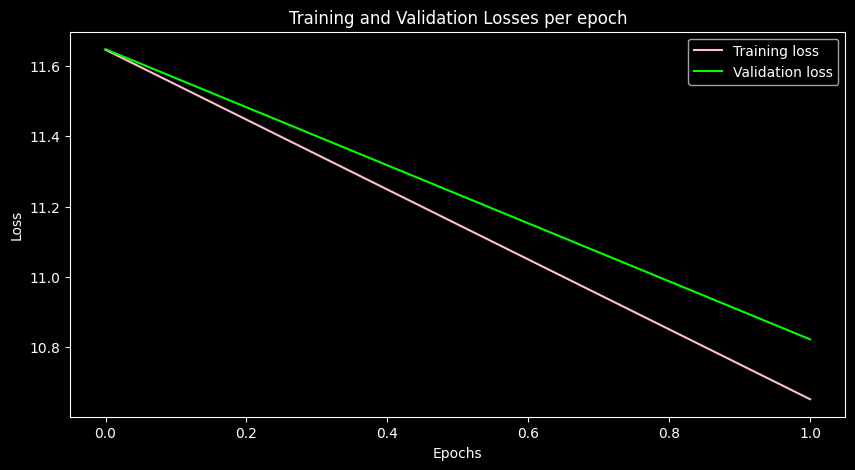

In [20]:
# Call the function
plot_losses(losses_list)

## Testing
### Init testing

In [21]:
config = TransformerConfig(tokenizer, visualize=True)
# First, you need to initialize the model
model2 = Transformer(config)
# Then, load the state dict
model2.load_model('./out/transformer_state_dict.pth')
# If you are ready to perform inference (and not training), put the model in evaluation mode
model2.eval()
print()

Number of Encoder parameters: 57.64M
number of parameters: 59.73M



### Testing

In [22]:
test_loss = estimate_loss(model2, dataset, config, ['test'])
test_loss['test'].item()

Evaluation - test:   0%|          | 0/2 [00:00<?, ?it/s]

10.934051513671875

## Visualization of attentions
### Specific sentence translation

In [23]:
def translate(sentences, tokenizer, model):
    """
    This function tokenizes input sentences, translates them using the provided model,
    and decodes the output into human-readable text. It also returns the attention dictionary from the model.

    Args:
        - sentences (list[str]): List of sentences to be translated.
        - tokenizer (Tokenizer): Tokenizer used for encoding and decoding sequences.
        - model (Transformer): The model used for translation.

    Returns:
        - decode_output (list[str]): List of translated sentences.
        - attn (dict): Dictionary containing attention information from the last layer of the model.
    """
    # Tokenize sentences
    tknzr = tokenizer.encoder
    sequences = []

    # Encode each sentence and add it to the list of sequences
    for sentence in sentences:
        sequence = tokenizer.sequence_padding(tknzr.encode(sentence)).unsqueeze(dim=0)
        sequences.append(sequence)

    # Concatenate the sequences into a tensor
    sequences = torch.cat(sequences, dim=0)

    # Set the model to evaluation mode and translate sentences
    model.eval()
    outputs, attn = model.translate_beam_search(sequences)

    # Initialize a list to store the decoded sentences
    decode_output = []

    # Decode each output sequence and add it to the list of decoded outputs
    for output in outputs:
        output = tokenizer.sequence_cleaner(output)
        decode_output += [tknzr.decode(output)]

    # Return the decoded sentences and the attention dictionary
    return decode_output, attn

In [24]:
input = ['I am a teacher.']
# expected_output = ['Je suis un professeur.']

In [25]:
outputs, attentions = translate(input, tokenizer, model2)

512/512

In [26]:
outputs

[',,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,']

### Formatting attention

In [27]:
def format_attn(input, output, attentions, batch: int = 0):
    """
    This function formats the attention outputs and tokenized inputs and outputs for easier interpretation and visualization.

    Args:
        - input (str): The original input sentence.
        - output (str): The translated output sentence.
        - attentions (dict): A dictionary containing the attention information from the model.
        - batch (int, optional): The batch index to format. Defaults to 0.

    Returns:
        - tokens_input (list[str]): The tokenized input sentence, padded to max_len.
        - tokens_output (list[str]): The tokenized output sentence, padded to max_len.
        - tensor_encoder_attn (torch.Tensor): The attention tensor for the encoder, trimmed and reshaped.
        - tensor_cross_attn (torch.Tensor): The cross-attention tensor, trimmed and reshaped.
        - tensor_decoder_attn (torch.Tensor): The attention tensor for the decoder, trimmed and reshaped.
    """

    # Stack the attention tensors along a new dimension
    tensor_encoder_attn = torch.stack(attentions['encoder_attn'], dim=0)
    tensor_cross_attn = torch.stack(attentions['cross_attn'], dim=0)
    tensor_decoder_attn = torch.stack(attentions['decoder_attn'], dim=0)

    # Tokenize the input and output sentences
    tokens_input = tokenizer.tokenize_from_str(input[batch])
    tokens_output = tokenizer.tokenize_from_str(output[batch])

    # Find the maximum length of the input and output tokens
    max_len = max(len(tokens_input), len(tokens_output))

    # If the input tokens are shorter than the max length, pad with empty strings
    if len(tokens_input) < max_len:
        tokens_input = tokens_input + [''] * (max_len - len(tokens_input))
    # Otherwise, pad the output tokens with empty strings
    else:
        tokens_output = tokens_output + [''] * (max_len - len(tokens_output))

    # Trim and reshape the attention tensors
    tensor_encoder_attn = tensor_encoder_attn[:, batch:batch+1, :, 1:max_len+1, 1:max_len+1] # layers, batch, heads, seq_len, seq_len
    tensor_cross_attn = tensor_cross_attn[:, batch:batch+1, :, 1:max_len+1, 1:max_len+1] # layers, batch, heads, seq_len, seq_len
    tensor_decoder_attn = tensor_decoder_attn[:, batch:batch+1, :, 1:max_len+1, 1:max_len+1] # layers, batch, heads, seq_len, seq_len

    # Return the formatted tokens and attention tensors
    return tokens_input, tokens_output, tensor_encoder_attn, tensor_cross_attn, tensor_decoder_attn

In [31]:
tokens_input,\
tokens_output,\
tensor_encoder_attn,\
tensor_cross_attn,\
tensor_decoder_attn = format_attn(input, outputs, attentions)

### Bertviz Model view

In [32]:
model_view(
    encoder_attention=tensor_encoder_attn,
    decoder_attention=tensor_decoder_attn,
    cross_attention=tensor_cross_attn,
    encoder_tokens=tokens_input,
    decoder_tokens=tokens_output
)

<IPython.core.display.Javascript object>

### Bertviz Head view

In [33]:
head_view(
    encoder_attention=tensor_encoder_attn,
    decoder_attention=tensor_decoder_attn,
    cross_attention=tensor_cross_attn,
    encoder_tokens=tokens_input,
    decoder_tokens=tokens_output
)

<IPython.core.display.Javascript object>